In [12]:
import torch.nn as nn
import torch
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from apex import amp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import glob
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from torch.utils.tensorboard import SummaryWriter
import time

# create nn module for ConvNet model
class ContactModel(nn.Module):
    def __init__(self,dr=0.1):
        super(ContactModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, kernel_size=6),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(dr))
        
        self.linear = nn.Sequential(
            nn.Linear(32*27*27,64),
            nn.ReLU(),
            nn.Dropout(dr),
            nn.Linear(64,1))
    def forward(self,x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1) # where x.size(0) is the batch size
        x = self.linear(x)
        return x

class ContactDataset(torch.utils.data.Dataset):
    def __init__(self, images, dock_score):
        'Initialization'
        self.images = images
        self.dock_score = dock_score

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dock_score)

    def __getitem__(self, index):
        'Generates one sample of data'
        X = self.images[index]
        y = self.dock_score[index]
        return X, y
    
# load data
def load_data():
    with open('dset.pkl', 'rb') as pickle_file:
        x,y = pickle.load(pickle_file)
    scaler = MinMaxScaler()
    y = np.abs(y)
    y = scaler.fit_transform(y.reshape(-1,1))
    x = torch.FloatTensor(x)
    x = np.transpose(x,(0,3,1,2))
    y = torch.FloatTensor(y)
    return x, y, scaler
    

In [13]:
# main
x,y, scaler = load_data()

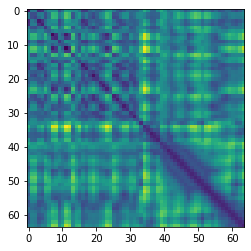

In [14]:
plt.imshow(x[0][0])

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2, shuffle=True)
train_dataset = ContactDataset(x_train,y_train)
test_dataset = ContactDataset(x_val,y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=64, num_workers=0)

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = ContactModel()
model.to(device)

ContactModel(
  (cnn): Sequential(
    (0): Conv2d(2, 8, kernel_size=(6, 6), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=23328, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [17]:

# create loss function and optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()
model, opt = amp.initialize(model, opt, opt_level='O2')
writer = SummaryWriter(f'tensorboard/')
# epoch loop
num_epochs=50
loss_train_store=[]
loss_test_store=[]
step=0
for i in range(num_epochs):
    model.train()
    # Training
    loss_acc=0
    iters=0
    start = time.time()
    for local_batch, local_labels in train_dataloader:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        #train
        y_pred = model(local_batch)
        loss_train = criterion(y_pred.flatten(),local_labels.flatten())
        
        #backprop + update
        opt.zero_grad()
        with amp.scale_loss(loss_train, opt) as scaled_loss:
            scaled_loss.backward()
        opt.step()
        
        loss_acc+=loss_train.item()
        iters+=1
        writer.add_scalar('Training_loss', loss_train, global_step=step)
        step+=1
        
    loss_train_store.append(loss_acc/iters)
    
    # Testing
    loss_acc=0
    iters=0
    y_pred_values=[]
    y_test_values=[]
    with torch.no_grad():
        for local_batch, local_labels in test_dataloader:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            #train
            y_pred = model(local_batch)
            loss_test = criterion(y_pred.flatten(),local_labels.flatten())
            loss_acc+=loss_test.item()
            iters+=1
            y_pred_values.append(y_pred.cpu())
            y_test_values.append(local_labels.cpu())
    y_pred_values = [item for sublist in y_pred_values for item in sublist]    
    y_test_values = [item for sublist in y_test_values for item in sublist]    

    r2_epoch = r2_score( y_test_values, y_pred_values)    
    loss_test_store.append(loss_acc/iters)
    print(i, loss_train_store[-1], loss_test_store[-1], r2_epoch)
    end = time.time()
    print(end-start)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
0 0.016384990187361836 0.0061535306579552276 0.8496979353839911
9.455512046813965
1 0.004978866360150278 0.0045243926380978934 0.8895766829424163
9.562304496765137


KeyboardInterrupt: 

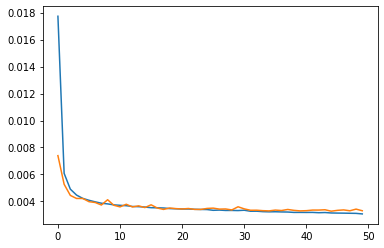

In [29]:
plt.plot(loss_train_store, label='train loss')
plt.plot(loss_test_store, label='test loss')

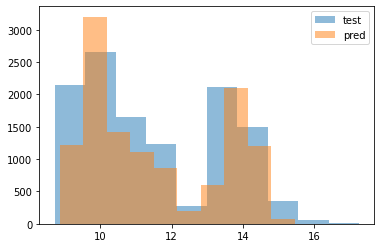

In [30]:
test = scaler.inverse_transform(np.array(y_test_values).reshape(-1,1))
pred = scaler.inverse_transform(np.array(y_pred_values).reshape(-1,1))

plt.hist(test, label="test", alpha=0.5)
plt.hist(pred, label="pred", alpha=0.5)

plt.legend()

In [ ]:
plt.hist(y_train)